# VAE - Hard EM 

In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "2"

In [3]:
import hlax
import json
import tomli
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
def build_iwmll_df(output_test):
    df_all = []
    for key in output_test:
        df_mll = pd.DataFrame.from_dict(output_test[key])
        df_mll.columns = ["hard-em", "vae"]
        df_mll = pd.DataFrame.from_dict(output_test[key])
        df_mll.columns = [f"hard-em", "vae"]
        df_mll = df_mll.melt(value_name="mll")
        df_mll["episode"] = int(key.lstrip("e"))
        df_all.append(df_mll)
    df_all = pd.concat(df_all, axis=0)
    return df_all

In [6]:
experiments = sorted(glob("../experiments/outputs/*.pkl"))
print(*experiments, sep="\n")

../experiments/outputs/experiment-20221102-071400-conv.pkl
../experiments/outputs/experiment-20221102-075614-mlp.pkl


In [11]:
path_experiment = experiments[-2]
with open(path_experiment, "rb") as f:
    experiment = pickle.load(f)

In [12]:
path_config = os.path.join("..", experiment["metadata"]["path_config"])
with open(path_config, "r") as f:
    config = f.read()

print(config)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[warmup]
    num_obs = 10000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1250, 1500, 2000, 2250, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [warmup.vae]
        num_is_samples = 10
    [warmup.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10


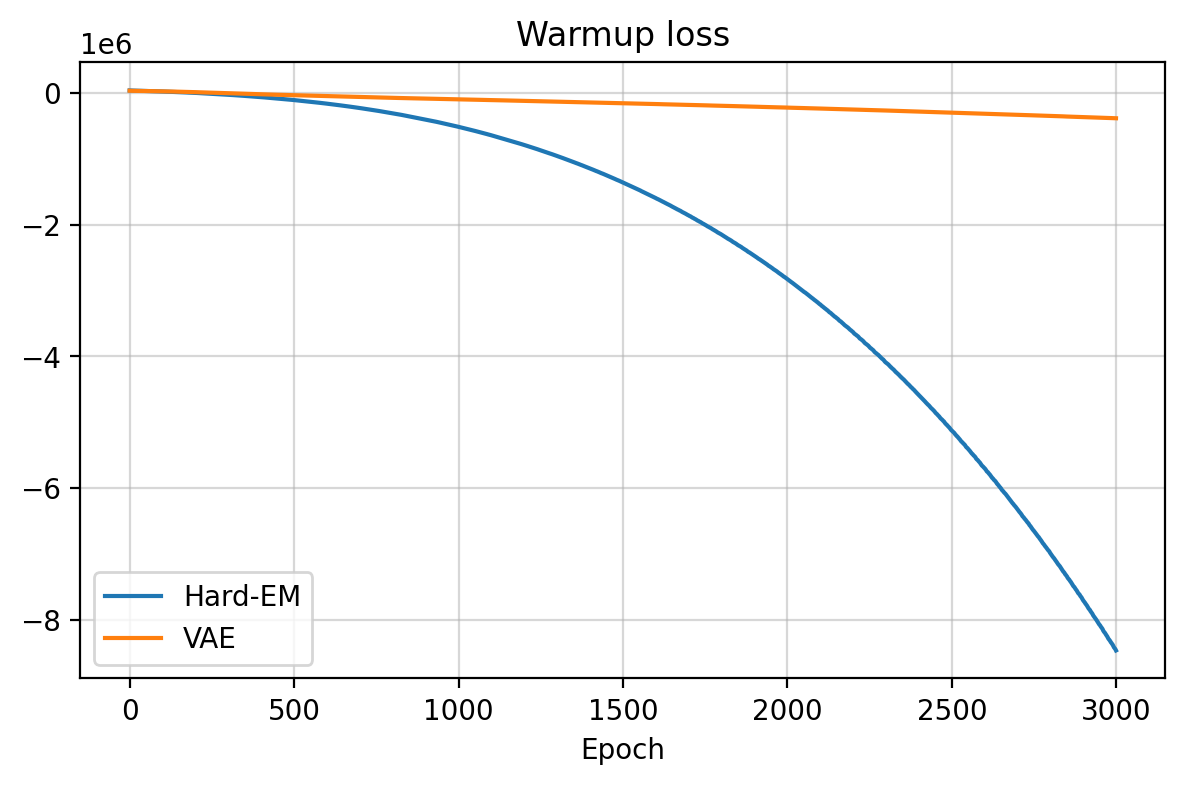

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(experiment["warmup"]["hardem"]["hist_loss"], label="Hard-EM")
plt.plot(experiment["warmup"]["vae"]["hist_loss"], label="VAE")
plt.legend()
plt.title("Warmup loss")
plt.xlabel("Epoch")
plt.grid(alpha=0.5)

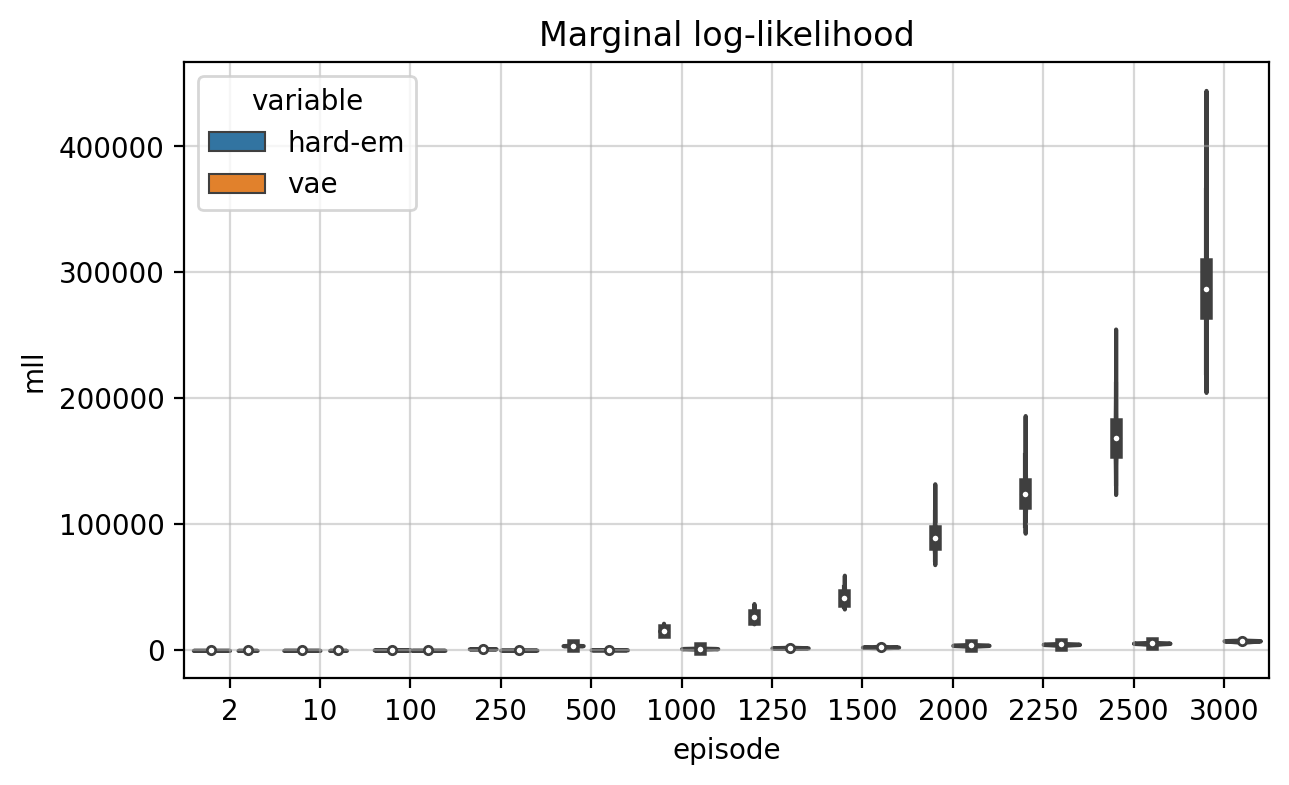

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))
df_all = build_iwmll_df(experiment["test"])
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all)
plt.title("Marginal log-likelihood")
plt.grid(alpha=0.5)